In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
%pylab inline
import pandas as pd
import json
import seaborn
import copy
import os
from Chapter2.CreateDataset import CreateDataset
from util.VisualizeDataset import VisualizeDataset
from Chapter3.OutlierDetection import DistributionBasedOutlierDetection
from Chapter3.OutlierDetection import DistanceBasedOutlierDetection
from Chapter3.DataTransformation import LowPassFilter
from Chapter3.DataTransformation import PrincipalComponentAnalysis
from Chapter3.ImputationMissingValues import ImputationMissingValues
from Chapter3.KalmanFilters import KalmanFilters
from Chapter4.TemporalAbstraction import NumericalAbstraction
from Chapter4.TemporalAbstraction import CategoricalAbstraction
from Chapter4.FrequencyAbstraction import FourierTransformation
from Chapter4.TextAbstraction import TextAbstraction
from util.VisualizeDataset import VisualizeDataset
from util import util
from util.parser import get_labels,generate_csv,generate_labels,get_sensor_values
import time
print(os.getcwd())

Populating the interactive namespace from numpy and matplotlib
/home/cts/Desktop/ML4QS/Assignments/assignments_code_git/assignment3


# 0. Below cell has global variables (path-names mostly)

In [14]:
dataset_folder = './datasets'
figures_folder = './figures'
files = os.listdir(dataset_folder)
print(files)
dataset_fname  = 'log_assignment3'
event_fname = 'log_events_assignment3'
result_dataset_path = './intermediate_datafiles/'
csv_dataset_path = os.path.join(dataset_folder,'csv/')
dataset_path = os.path.join(dataset_folder,dataset_fname)
event_path = os.path.join(dataset_folder,event_fname)
output_fname = 'dataset.csv'

['log_assignment2', 'log_events_assignment3', 'log_assignment3', 'csv', 'log_events_assignment2']


In [15]:
if not os.path.exists(result_dataset_path):
    print('Creating result directory: ' + result_dataset_path)
    os.makedirs(result_dataset_path)
if not os.path.exists(csv_dataset_path):
    print('Creating result directory: ' + csv_dataset_path)
    os.makedirs(csv_dataset_path)
if not os.path.exists(figures_folder):
    print('Creating result directory: ' + figures_folder)
    os.makedirs(figures_folder)

# SECTION 1 : DATA PREPARATION

### 1. LOG PARSING FUNCTION CALL

In [4]:
labels = get_labels(dataset_path)
print('Label Mappings:\n')
print(json.dumps(labels,indent=2))


Label Mappings:

{
  "stairsdown": [
    1, 
    3, 
    5, 
    7, 
    9, 
    11
  ], 
  "stairsup": [
    2, 
    4, 
    6, 
    8, 
    10, 
    12
  ], 
  "walking": [
    13
  ]
}


In [5]:
sensors_dict = get_sensor_values(dataset_path)
print('Sensors in log file')
sensors = sensors_dict.keys()
print(json.dumps(sensors,indent=2))

Sensors in log file
[
  "bmi160 accelerometer", 
  "bmi160 gyroscope", 
  "rotation vector"
]


## 1.2 CSV generation cell

In [6]:
for sensor in sensors:
    if sensor == 'rotation vector':
        generate_csv(sensors_dict[sensor],
                     header=['x','y','z','theta','phi','timestamp'],
                     fname = os.path.join(csv_dataset_path,sensor+'.csv'))
    else:
        generate_csv(sensors_dict[sensor],fname = os.path.join(csv_dataset_path,sensor+'.csv'))
generate_labels(fname=event_path,log_fname=dataset_path,fout=csv_dataset_path+'labels.csv');

### 1.3 Dataset creation cell (Most important here we tweak granularities)>

In [32]:
granularities = [50,100,250,1000,5000]
datasets = []
dataset_names = []

for milliseconds_per_instance in granularities:
    initial = time.time()
    # Create an initial dataset object with the base directory for our data and a granularity
    DataSet = CreateDataset(csv_dataset_path, milliseconds_per_instance)
    print('granularity is %d ms'%milliseconds_per_instance)
    
    DataSet.add_numerical_dataset('bmi160 accelerometer.csv','timestamp',['x','y','z'],'avg','acc_phone_')
    DataSet.add_numerical_dataset('bmi160 gyroscope.csv','timestamp',['x','y','z'],'avg','gyr_phone_')
    DataSet.add_numerical_dataset('rotation vector.csv','timestamp',['x','y','z','theta','phi'],'avg','rotation_phone_')
    DataSet.add_event_dataset('labels.csv','label_start','label_end','label','binary')
    print('Added all sensors and labels')
    dataset = DataSet.data_table
#     util.print_statistics(dataset)
    datasets.append(copy.deepcopy(dataset))
    fname = str(milliseconds_per_instance)+ '_dataset.csv'
    path = os.path.join(result_dataset_path,fname)
    dataset_names.append(fname)
    dataset.to_csv(path)
    print('Dataset created,\tDuration:%.5f seconds'%(time.time()-initial))
    print('====================================')
    


granularity is 50 ms
Added all sensors and labels
Dataset created,	Duration:68.06123 seconds
granularity is 100 ms
Added all sensors and labels
Dataset created,	Duration:32.17165 seconds
granularity is 250 ms
Added all sensors and labels
Dataset created,	Duration:13.43583 seconds
granularity is 1000 ms
Added all sensors and labels
Dataset created,	Duration:6.10183 seconds
granularity is 5000 ms
Added all sensors and labels
Dataset created,	Duration:2.15389 seconds


### 1.4 Some visualizations (this needs above cell to run)

[   0  209  418  627  836 1045 1254 1463 1672 1882 2091 2300 2509 2718 2927
 3136 3345 3554 3764 3973 4182 4391 4600 4809 5018 5227 5436 5646 5855 6064
 6273 6482 6691 6900 7109 7318 7528]
Using 50 milliseconds, size:7529 steps: 37


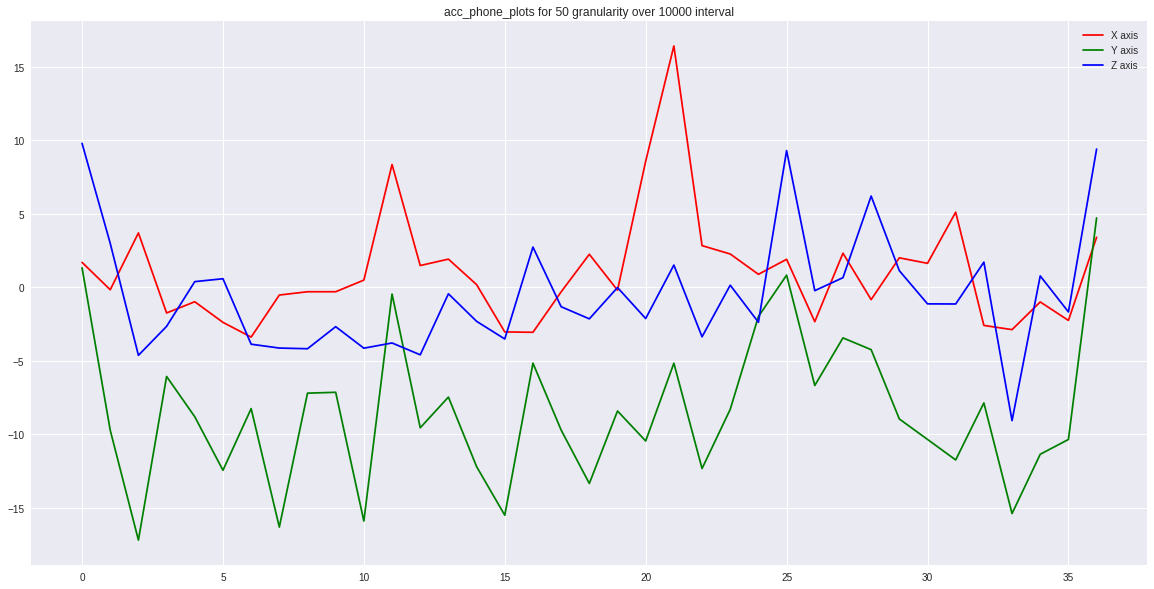

[   0  104  209  313  418  522  627  731  836  941 1045 1150 1254 1359 1463
 1568 1672 1777 1882 1986 2091 2195 2300 2404 2509 2613 2718 2823 2927 3032
 3136 3241 3345 3450 3554 3659 3764]
Using 100 milliseconds, size:3765 steps: 37


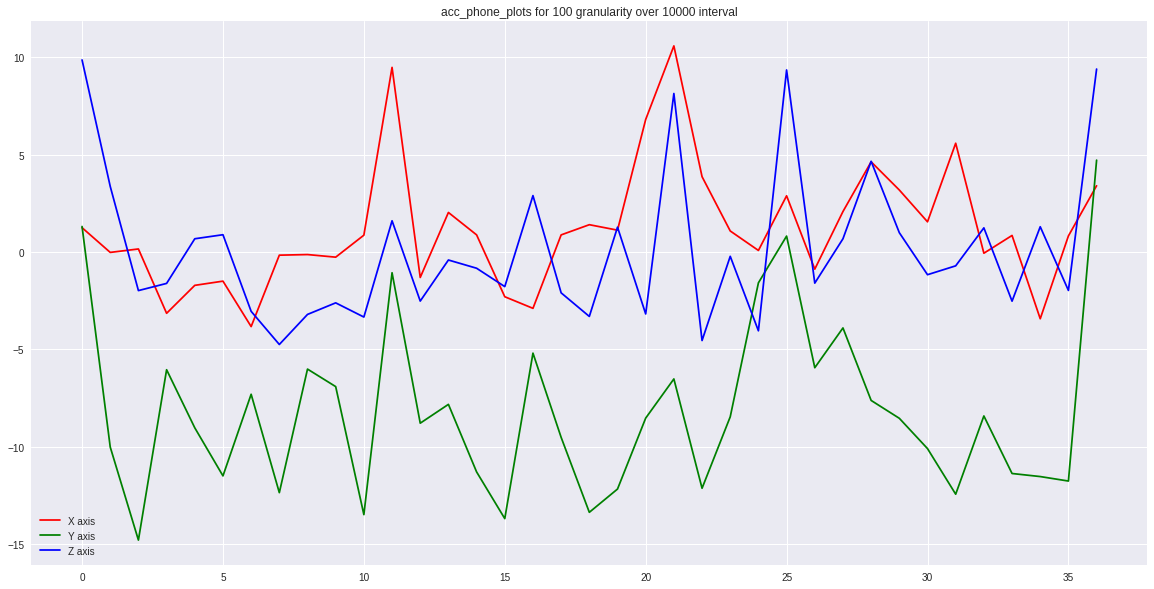

[   0   41   83  125  167  209  250  292  334  376  418  459  501  543  585
  627  668  710  752  794  836  877  919  961 1003 1045 1086 1128 1170 1212
 1254 1295 1337 1379 1421 1463 1505]
Using 250 milliseconds, size:1506 steps: 37


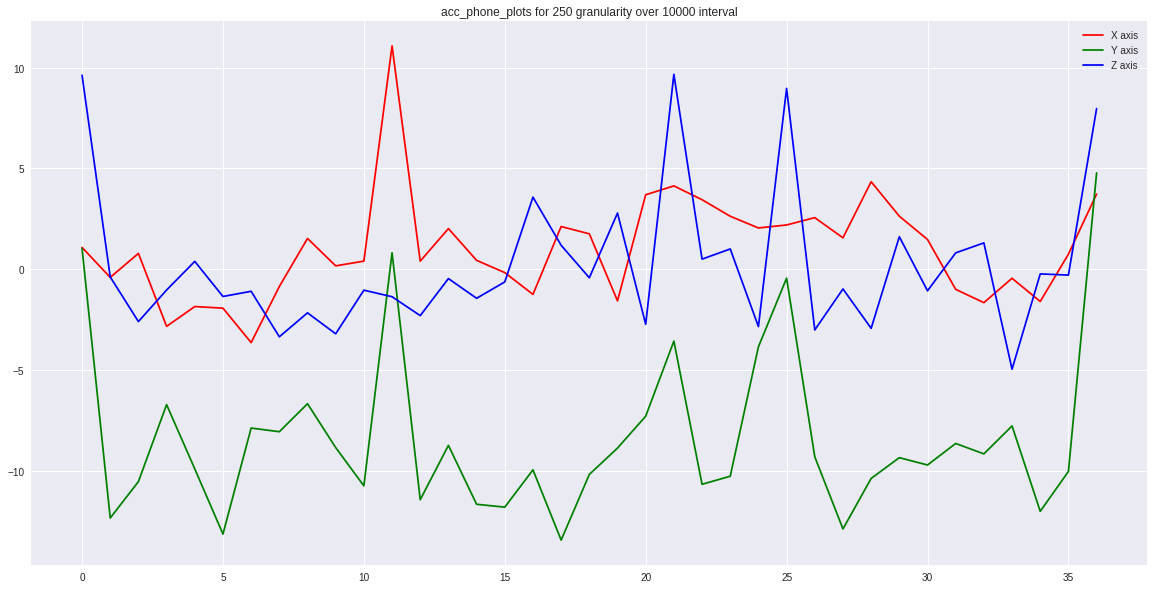

[ 0  2  4  6  8 10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40 42 44 46 48
 50 52 54 56 58 60 62 64 66 68 70 72 75]
Using 5000 milliseconds, size:76 steps: 38


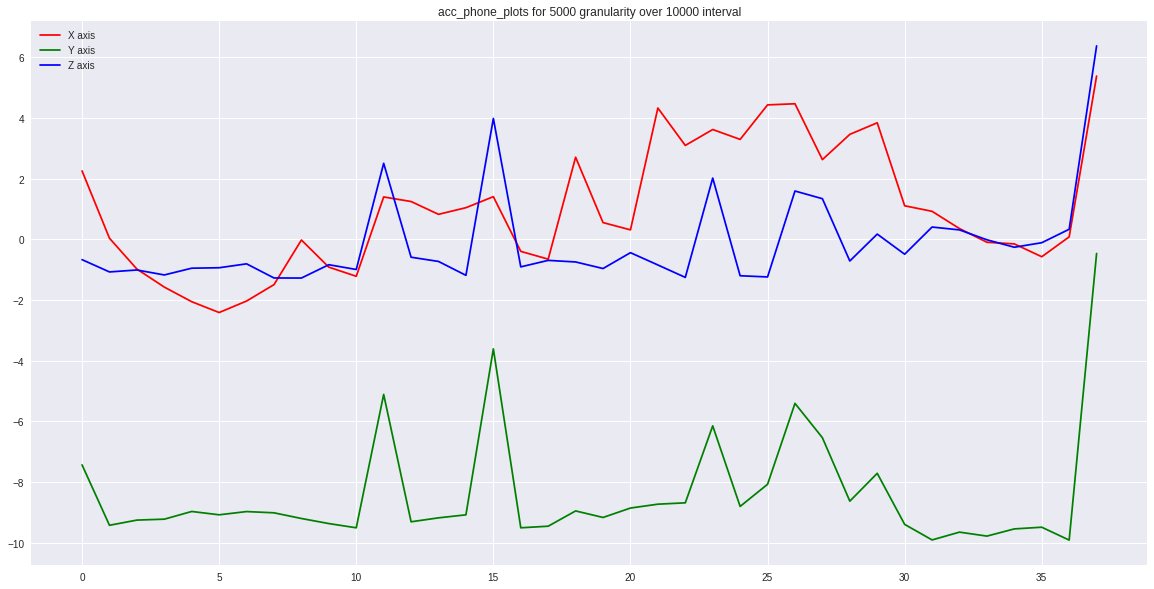

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37]
Using 10000 milliseconds, size:38 steps: 38


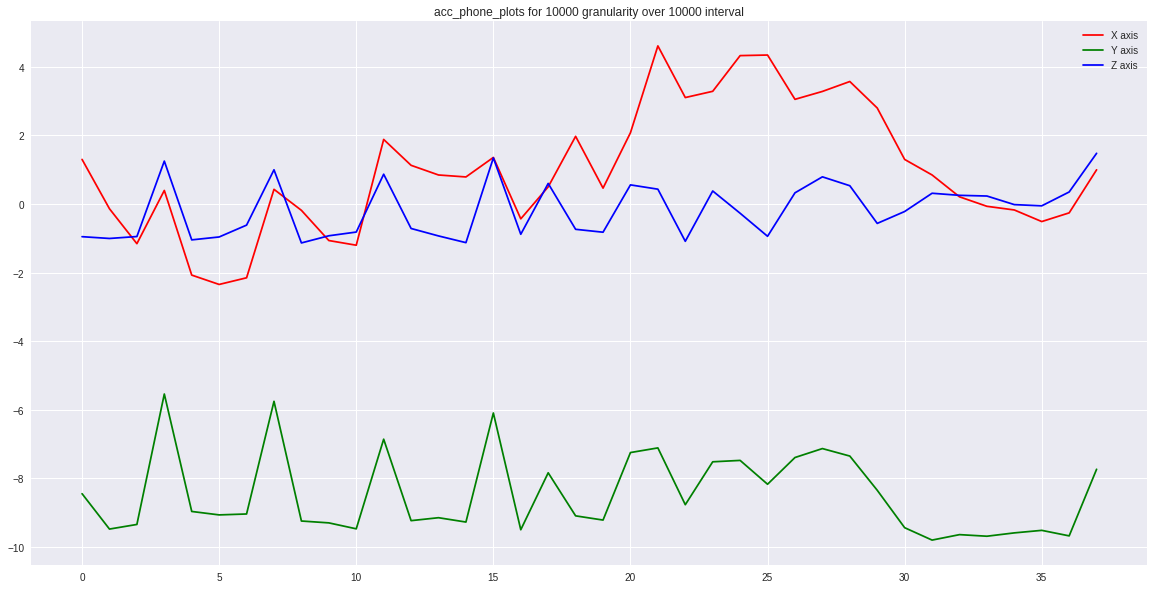

In [31]:
DataViz = VisualizeDataset()
rcParams['figure.figsize'] = (20,10)
interval = 10000 # 10 second interval plot

prefix = 'acc_phone_'
for d_index in range(len(datasets)):
    millis = granularities[d_index]
    indices = floor(np.linspace(0,len(datasets[d_index])-1,len(datasets[d_index])//(interval//millis)))
    indices = indices.astype(int)
    xx = np.arange(len(indices))
    print(indices)
    print('Using %d milliseconds, size:%d steps: %d'%(millis,len(datasets[d_index]),len(indices),))
    
    y1 = datasets[d_index][prefix+'x'][indices]
    y2 = datasets[d_index][prefix+'y'][indices]
    y3 = datasets[d_index][prefix+'z'][indices]
    plt.plot(xx,y1,'r')
    plt.plot(xx,y2,'g')
    plt.plot(xx,y3,'b')
    plt.legend(['X axis','Y axis','Z axis'])
    plt.title(prefix+'plots for %d granularity over %d interval'%(millis,interval))
    plt.savefig(os.path.join(figures_folder,prefix+str(millis)+'_'+'axes.png'))    
    plt.show()


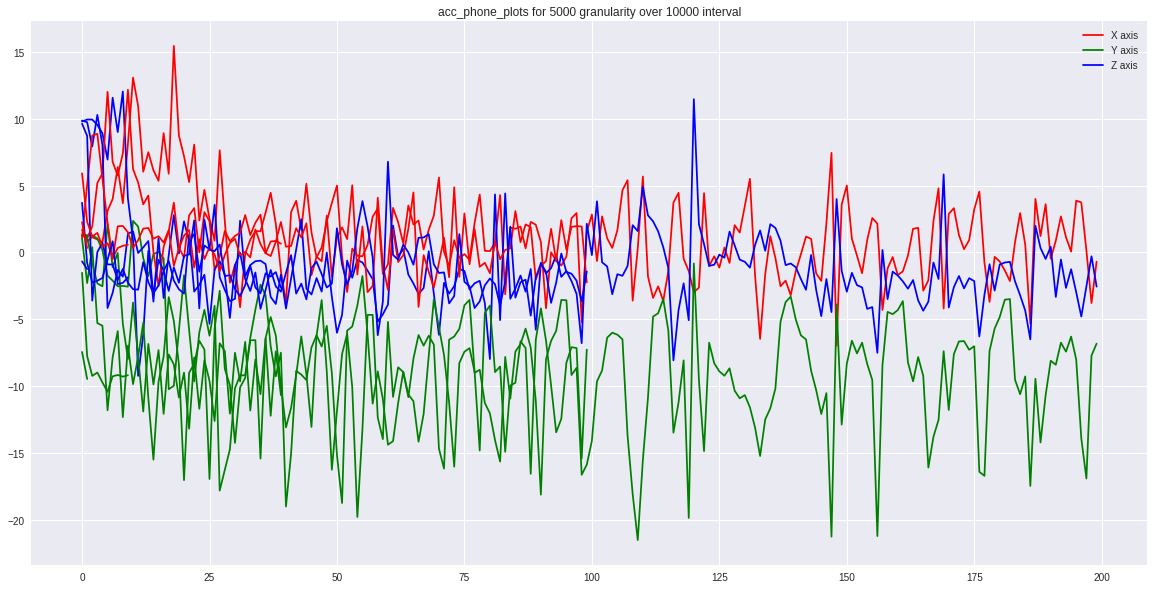

In [75]:
max_range = 10000
prefix = 'acc_phone_'
start_index = 0
for i in range(len(datasets)):
    millis = granularities[i]
    end_index = int(max_range/millis)
    start = datasets[i].index[start_index]
    
    end = datasets[i].index[end_index] -1
    indices = range(start_index,end_index)
    xx = np.arange(end_index)
#     print('millis:%d , start:%s\tend:%s'%(millis,str(start),str(end)))
    y1 = datasets[i][prefix+'x'][indices]
    y2 = datasets[i][prefix+'y'][indices]
    y3 = datasets[i][prefix+'z'][indices]
    plt.plot(xx,y1,'r')
    plt.plot(xx,y2,'g')
    plt.plot(xx,y3,'b')
    plt.legend(['X axis','Y axis','Z axis'])
    plt.title(prefix+'plots for %d granularity over %d interval'%(millis,interval))
#     plt.savefig(os.path.join(figures_folder,prefix+str(millis)+'over_'+str(max_range)+'_'+'axes.png'))    
plt.show()

## 1.5 More visualizations on tommie's request....

In [ ]:
DataViz = VisualizeDataset()
rcParams['figure.figsize'] = (20,10)
max_length = 10000 # 10 second interval plot

prefix = 'acc_phone_'
for d_index in range(len(datasets)):
    millis = granularities[d_index]
    indices = floor(np.linspace(0,len(datasets[d_index])-1,len(datasets[d_index])//(interval//millis)))
    indices = indices.astype(int)
    xx = np.arange(len(indices))
    print(indices)
    print('Using %d milliseconds, size:%d steps: %d'%(millis,len(datasets[d_index]),len(indices),))
    
    y1 = datasets[d_index][prefix+'x'][indices]
    y2 = datasets[d_index][prefix+'y'][indices]
    y3 = datasets[d_index][prefix+'z'][indices]
    plt.plot(xx,y1,'r')
    plt.plot(xx,y2,'g')
    plt.plot(xx,y3,'b')
    plt.legend(['X axis','Y axis','Z axis'])
    plt.title(prefix+'plots for %d granularity over %d interval'%(millis,interval))
    plt.savefig(os.path.join(figures_folder,prefix+str(millis)+'_'+'axes.png'))    
    plt.show()


# SECTION 2 Data Filtering Cell (U can continue from here)

In [110]:
### choose a dataset to filter:
data_index = 0
DataViz = VisualizeDataset()
rcParams['figure.figsize'] = (20,10)
data_index = 0
try:
    print(dataset_names)
    dataset = pd.read_csv(os.path.join(result_dataset_path,dataset_names[data_index])
                          ,index_col=0) # minimum granularity - biggest dataset
    millis = granularities[data_index]
    print(granularities)
except NameError:
    print(os.listdir(result_dataset_path))
    dataset_names = os.listdir(result_dataset_path)
    dataset_names = [x for x in datasets if 'dataset' in x and not 'lock' 
                     in x and not 'kalman' in x and not 'outlier' in x and not 'rest' in x
                     and not 'ws' in x]
    print(dataset_names)
    granularities = [int(x.split('_')[0]) for x in datasets if 'dataset' in x]
    dataset = pd.read_csv(os.path.join(result_dataset_path,datasets[data_index])
                          ,index_col=0) # minimum granularity - biggest dataset
    millis = granularities[data_index]
    
dataset.index = pd.to_datetime(dataset.index)
milliseconds_per_instance = (dataset.index[1] - dataset.index[0]).microseconds/1000
print("Using milliseconds per instance: %d"%milliseconds_per_instance)
outlier_columns = ['acc_phone_x', 'gyr_phone_y']
# dataset.head()

['50_dataset.csv', '100_dataset.csv', '250_dataset.csv', '5000_dataset.csv']
[50, 100, 250, 5000]
Using milliseconds per instance: 50


### Section 2.1 : Outlier detection 

In [112]:
OutlierDistr = DistributionBasedOutlierDetection()
OutlierDist = DistanceBasedOutlierDetection()

#And investigate the approaches for all relevant attributes.
for col in outlier_columns:
    # And try out all different approaches. Note that we have done some optimization
    # of the parameter values for each of the approaches by visual inspection.
    dataset = OutlierDistr.chauvenet(dataset, col)
#     DataViz.plot_binary_outliers(dataset, col, col + '_outlier')
    dataset = OutlierDistr.mixture_model(dataset, col)
#     DataViz.plot_dataset(dataset, [col, col + '_mixture'], ['like','like'], ['line', 'points'])
    # This requires:
    # n_data_points * n_data_points * point_size =
    # 31839 * 31839 * 64 bits = ~8GB available memory
    try:
        dataset = OutlierDist.simple_distance_based(dataset, [col], 'euclidean', 0.10, 0.99)
#         DataViz.plot_binary_outliers(dataset, col, 'simple_dist_outlier')
    except MemoryError as e:
        print('Not enough memory available for simple distance-based outlier detection...')
        print('Skipping.')
    
    try:
        dataset = OutlierDist.local_outlier_factor(dataset, [col], 'euclidean', 5)
#         DataViz.plot_dataset(dataset, [col, 'lof'], ['exact','exact'], ['line', 'points'])
    except MemoryError as e:
        print('Not enough memory available for lof...')
        print('Skipping.')

    # Remove all the stuff from the dataset again.
    cols_to_remove = [col + '_outlier', col + '_mixture', 'simple_dist_outlier', 'lof']
    for to_remove in cols_to_remove:
        if to_remove in dataset:
            del dataset[to_remove]

# We take Chauvent's criterion and apply it to all but the label data...

for col in [c for c in dataset.columns if not 'label' in c]:
#     print('Measurement is now: ' , col)
    dataset = OutlierDistr.chauvenet(dataset, col)
    dataset.loc[dataset[col + '_outlier'] == True, col] = np.nan
    del dataset[col + '_outlier']
dataset.to_csv(result_dataset_path +str(millis)+'_outlier.csv')

0th element
250th element
500th element
750th element
1000th element
1250th element
1500th element
1750th element
2000th element
2250th element
2500th element
2750th element
3000th element
3250th element
3500th element
3750th element
4000th element
4250th element
4500th element
4750th element
5000th element
5250th element
5500th element
5750th element
6000th element
6250th element
6500th element
6750th element
7000th element
7250th element
7500th element
0th element
250th element
500th element
750th element
1000th element
1250th element
1500th element
1750th element
2000th element
2250th element
2500th element
2750th element
3000th element
3250th element
3500th element
3750th element
4000th element
4250th element
4500th element
4750th element
5000th element
5250th element
5500th element
5750th element
6000th element
6250th element
6500th element
6750th element
7000th element
7250th element
7500th element


###  Section 2.2 Apply Kalman Filtering to the dataset 

Filtering out acc_phone_x value


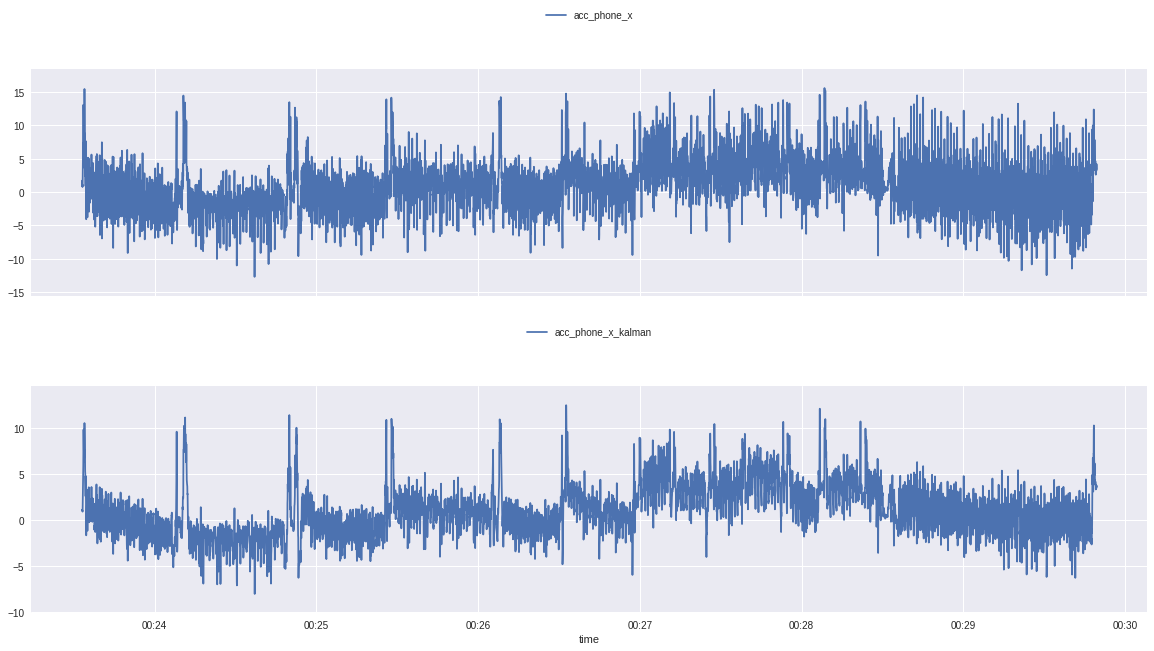

Filtering out acc_phone_y value
Filtering out acc_phone_z value
Filtering out gyr_phone_x value
Filtering out gyr_phone_y value
Filtering out gyr_phone_z value
Filtering out rotation_phone_x value
Filtering out rotation_phone_y value


In [113]:
rcParams['figure.figsize'] = (20,10)
missing_values = ['acc_phone_x','acc_phone_y','acc_phone_z','gyr_phone_x','gyr_phone_y','gyr_phone_z','rotation_phone_x','rotation_phone_y']

original_dataset = pd.read_csv(result_dataset_path+str(millis)+'_outlier.csv',index_col=0)
original_dataset.index = pd.to_datetime(original_dataset.index)
KalFilter = KalmanFilters()
value = missing_values[0]
print('Filtering out %s value'%value)
kalman_dataset = KalFilter.apply_kalman_filter(original_dataset,value)
DataViz.plot_dataset(kalman_dataset, [value,value+'_kalman'], ['exact','exact'], ['line', 'line'])
for value in missing_values[1:]:
    print('Filtering out %s value'%value)
    kalman_dataset = KalFilter.apply_kalman_filter(kalman_dataset,value)
#     DataViz.plot_dataset(kalman_dataset, [value,value+'_kalman'], ['exact','exact'], ['line', 'line'])
kalman_dataset.to_csv(result_dataset_path+'/'+str(millis)+'_kalman_dataset.csv')

### Section 2.3 Apply PCA to get principal component values.

['acc_phone_x_kalman', 'acc_phone_y_kalman', 'acc_phone_z_kalman', 'gyr_phone_x_kalman', 'gyr_phone_y_kalman', 'gyr_phone_z_kalman', 'rotation_phone_x_kalman', 'rotation_phone_y_kalman', 'rotation_phone_z', 'rotation_phone_theta', 'rotation_phone_phi']


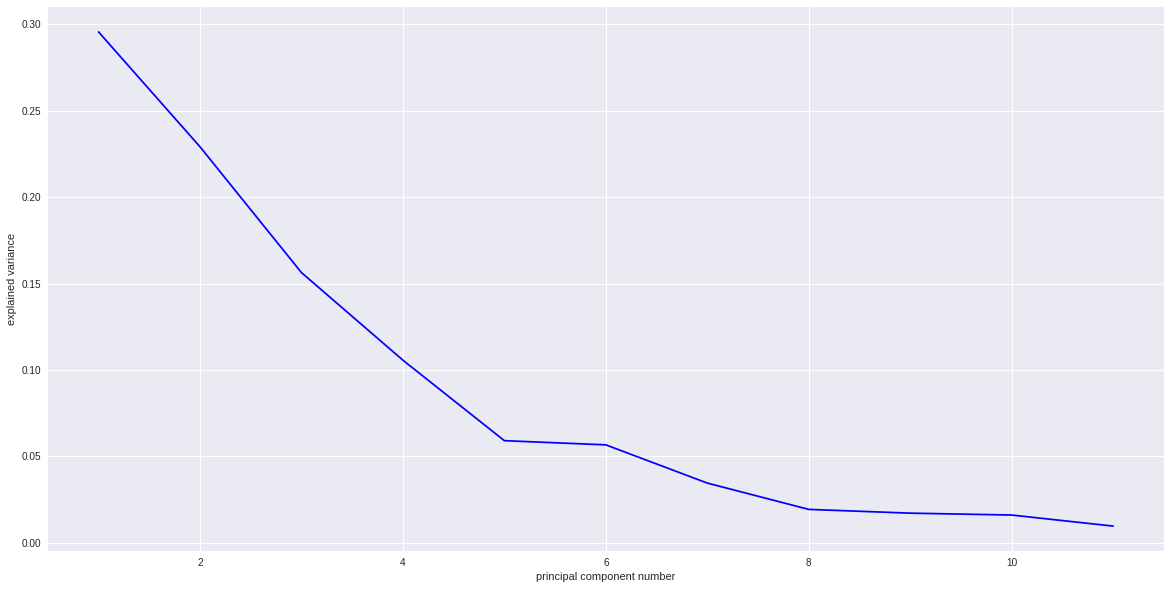

In [82]:
PCA = PrincipalComponentAnalysis()
# selected_predictor_cols = [c for c in dataset.columns if (not ('label' in c)) and (not (c == 'rotation_phone_theta'))]
selected_predictor_cols = missing_values
selected_predictor_cols = [x+'_kalman' for x in selected_predictor_cols]
selected_predictor_cols += ['rotation_phone_z','rotation_phone_theta','rotation_phone_phi']
print(selected_predictor_cols)
pc_values = PCA.determine_pc_explained_variance(kalman_dataset, selected_predictor_cols)
plt.plot(range(1, len(selected_predictor_cols)+1), pc_values, 'b-')
plt.xlabel('principal component number')
plt.ylabel('explained variance')
plt.show()
#Derived from the plot
n_pcs = 6

In [105]:

kalman_dataset = PCA.apply_pca(copy.deepcopy(kalman_dataset), selected_predictor_cols, n_pcs)
kalman_dataset.head()

,acc_phone_x,acc_phone_y,acc_phone_z,gyr_phone_x,gyr_phone_y,gyr_phone_z,rotation_phone_x,rotation_phone_y,rotation_phone_z,rotation_phone_theta,...,gyr_phone_y_kalman,gyr_phone_z_kalman,rotation_phone_x_kalman,rotation_phone_y_kalman,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6
2017-06-25 00:23:33.041,1.073467,1.022982,9.618707,-0.080865,-0.487557,0.130201,-0.028442,-0.111544,-0.740998,0.661367,...,-0.551076,0.698893,-0.074141,-0.168135,0.213013,0.723151,0.669525,0.700200,0.015391,0.112033
2017-06-25 00:23:33.291,5.061155,-2.286908,8.710447,1.739781,NaN,2.473014,-0.208022,-0.271435,-0.590785,0.705897,...,-0.551076,1.494844,-0.160144,-0.235926,0.123760,0.742736,0.654065,0.810786,-0.085025,0.060405
2017-06-25 00:23:33.541,8.732074,0.395490,-3.603068,0.822212,-1.882731,0.566902,-0.282120,-0.673999,-0.146337,0.662875,...,-1.413833,1.000998,-0.242299,-0.537920,-0.109816,0.799935,0.588256,0.618185,-0.291441,0.320644
2017-06-25 00:23:33.791,8.862734,-5.279615,0.031667,-0.701653,1.304043,1.824373,-0.417628,-0.611520,-0.099451,0.654674,...,0.212429,1.453682,-0.360965,-0.588891,-0.136522,0.790427,0.461178,0.557737,-0.507841,0.268515
2017-06-25 00:23:34.041,5.515203,-5.477578,0.720733,0.013605,-0.455154,1.994326,-0.568054,-0.445605,0.013449,0.685121,...,-0.181582,1.752836,-0.501198,-0.489618,-0.124803,0.835892,0.336961,0.514896,-0.444325,0.259642


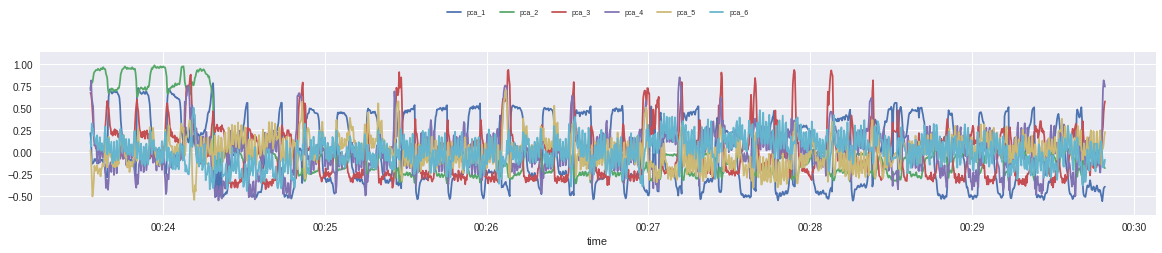

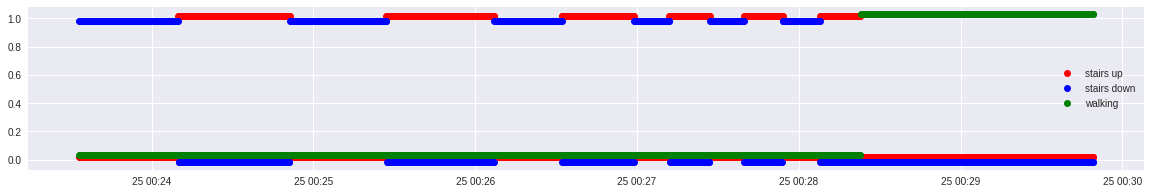

In [117]:
rcParams['figure.figsize'] = (20,3)
DataViz.plot_dataset(kalman_dataset, ['pca_'], ['like'], ['line'])
plt.plot(kalman_dataset['labelstairsup']+0.02,'ro')
plt.plot(kalman_dataset['labelstairsdown']-0.02,'bo')
plt.plot(kalman_dataset['labelwalking']+0.03,'go')
plt.legend(['stairs up','stairs down','walking'])
plt.show()

In [122]:
kalman_dataset.to_csv(result_dataset_path+'/'+str(millis)+'_dataset_rest.csv')

# Section 3 : Chapter4 -  Feature Engineering

In [73]:
### choose a dataset to filter:
DataViz = VisualizeDataset()
millis = 50
rcParams['figure.figsize'] = (20,10)
dataset = pd.read_csv(os.path.join(result_dataset_path,str(millis)+'_dataset_rest.csv'),index_col=0)
dataset.index = pd.to_datetime(dataset.index)
milliseconds_per_instance = (dataset.index[1] - dataset.index[0]).microseconds/1000
print("Using milliseconds per instance: %d"%milliseconds_per_instance)
dataset.head()

Using milliseconds per instance: 250


,acc_phone_x,acc_phone_y,acc_phone_z,gyr_phone_x,gyr_phone_y,gyr_phone_z,rotation_phone_x,rotation_phone_y,rotation_phone_z,rotation_phone_theta,...,gyr_phone_y_kalman,gyr_phone_z_kalman,rotation_phone_x_kalman,rotation_phone_y_kalman,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6
2017-06-25 00:23:33.041,1.073467,1.022982,9.618707,-0.080865,-0.487557,0.130201,-0.028442,-0.111544,-0.740998,0.661367,...,-0.551076,0.698893,-0.074141,-0.168135,0.213013,0.723151,0.669525,0.700200,0.015391,0.112033
2017-06-25 00:23:33.291,5.061155,-2.286908,8.710447,1.739781,NaN,2.473014,-0.208022,-0.271435,-0.590785,0.705897,...,-0.551076,1.494844,-0.160144,-0.235926,0.123760,0.742736,0.654065,0.810786,-0.085025,0.060405
2017-06-25 00:23:33.541,8.732074,0.395490,-3.603068,0.822212,-1.882731,0.566902,-0.282120,-0.673999,-0.146337,0.662875,...,-1.413833,1.000998,-0.242299,-0.537920,-0.109816,0.799935,0.588256,0.618185,-0.291441,0.320644
2017-06-25 00:23:33.791,8.862734,-5.279615,0.031667,-0.701653,1.304043,1.824373,-0.417628,-0.611520,-0.099451,0.654674,...,0.212429,1.453682,-0.360965,-0.588891,-0.136522,0.790427,0.461178,0.557737,-0.507841,0.268515
2017-06-25 00:23:34.041,5.515203,-5.477578,0.720733,0.013605,-0.455154,1.994326,-0.568054,-0.445605,0.013449,0.685121,...,-0.181582,1.752836,-0.501198,-0.489618,-0.124803,0.835892,0.336961,0.514896,-0.444325,0.259642


[20, 120, 480]


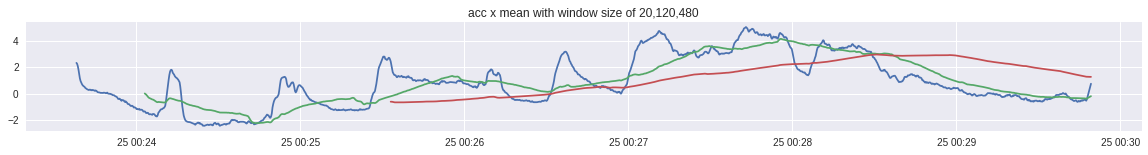

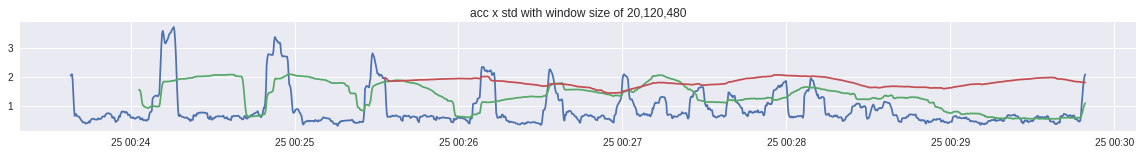

In [74]:
window_sizes = [int(float(5000)/milliseconds_per_instance), int(float(0.5*60000)/milliseconds_per_instance), int(float(2.*60000)/milliseconds_per_instance)]
print(window_sizes)
NumAbs = NumericalAbstraction()
CatAbs = CategoricalAbstraction()

dataset_copy = copy.deepcopy(dataset)
for ws in window_sizes:
    dataset_copy = NumAbs.abstract_numerical(dataset_copy, ['acc_phone_x_kalman'], ws, 'mean')
    dataset_copy = NumAbs.abstract_numerical(dataset_copy, ['acc_phone_x_kalman'], ws, 'std')
rcParams['figure.figsize'] = (20,2)
plt.plot(dataset_copy['acc_phone_x_kalman_temp_mean_ws_20'])
plt.plot(dataset_copy['acc_phone_x_kalman_temp_mean_ws_120'])
plt.plot(dataset_copy['acc_phone_x_kalman_temp_mean_ws_480'])
plt.title('acc x mean with window size of 20,120,480')
plt.show()
plt.plot(dataset_copy['acc_phone_x_kalman_temp_std_ws_20'])
plt.plot(dataset_copy['acc_phone_x_kalman_temp_std_ws_120'])
plt.plot(dataset_copy['acc_phone_x_kalman_temp_std_ws_480'])
plt.title('acc x std with window size of 20,120,480')
plt.show()

In [76]:
# DataViz.plot_dataset(dataset_copy, ['acc_phone_x', 'acc_phone_x_temp_mean', 'acc_phone_x_temp_std'], ['exact', 'like', 'like'], ['line', 'line', 'line'])
# print(dataset_copy.keys())
print(dataset.columns)
ws = int(float(0.1*60000)/milliseconds_per_instance)
selected_predictor_cols = [c for c in dataset.columns if not 'label' in c]
dataset_ws = NumAbs.abstract_numerical(dataset, selected_predictor_cols, ws, 'mean')
print("doing mean numerical abstraction")
dataset_ws = NumAbs.abstract_numerical(dataset_ws, selected_predictor_cols, ws, 'std')
print('now doing categorical abstraction')
dataset_ws = CatAbs.abstract_categorical(dataset_ws, ['label'], ['like'], 0.03, int(float(5*60000)/milliseconds_per_instance), 2)

dataset_ws.to_csv(result_dataset_path+'/'+'dataset_ws_'+str(ws)+'.csv')


Index([u'acc_phone_x', u'acc_phone_y', u'acc_phone_z', u'gyr_phone_x',
       u'gyr_phone_y', u'gyr_phone_z', u'rotation_phone_x',
       u'rotation_phone_y', u'rotation_phone_z', u'rotation_phone_theta',
       u'rotation_phone_phi', u'labelstairsdown', u'labelstairsup',
       u'labelwalking', u'acc_phone_x_kalman', u'acc_phone_y_kalman',
       u'acc_phone_z_kalman', u'gyr_phone_x_kalman', u'gyr_phone_y_kalman',
       u'gyr_phone_z_kalman', u'rotation_phone_x_kalman',
       u'rotation_phone_y_kalman', u'pca_1', u'pca_2', u'pca_3', u'pca_4',
       u'pca_5', u'pca_6', u'acc_phone_x_temp_mean_ws_24',
       u'acc_phone_y_temp_mean_ws_24', u'acc_phone_z_temp_mean_ws_24',
       u'gyr_phone_x_temp_mean_ws_24', u'gyr_phone_y_temp_mean_ws_24',
       u'gyr_phone_z_temp_mean_ws_24', u'rotation_phone_x_temp_mean_ws_24',
       u'rotation_phone_y_temp_mean_ws_24',
       u'rotation_phone_z_temp_mean_ws_24',
       u'rotation_phone_theta_temp_mean_ws_24',
       u'rotation_phone_phi_temp_me

### Frequency Domain - Fourier Transformations.

In [90]:
milliseconds_per_instance = 250
ws = int(float(0.1*60000)/milliseconds_per_instance)
dataset = pd.read_csv(os.path.join(result_dataset_path,'dataset_ws_'+str(ws)+'.csv'),index_col=0)
FreqAbs = FourierTransformation()
fs = float(float(1000)/milliseconds_per_instance)
print("Frequency for FFT: %5.5f"%fs)
periodic_predictor_cols =['acc_phone_x_kalman', 'acc_phone_y_kalman',
                          'acc_phone_z_kalman', 'gyr_phone_x_kalman', 
                          'gyr_phone_y_kalman', 'gyr_phone_z_kalman', 
                          'rotation_phone_x_kalman', 'rotation_phone_y_kalman', 
                          'rotation_phone_z', 'rotation_phone_theta', 'rotation_phone_phi']
col = periodic_predictor_cols[0]
print('FFT in column %s'%col)
dataset_fft = FreqAbs.abstract_frequency(dataset, [col], int(float(10000)/milliseconds_per_instance), fs)
for col in periodic_predictor_cols[1:]:
    print('FFT in column %s'%col)
    dataset_fft = FreqAbs.abstract_frequency(dataset_fft, [col], int(float(10000)/milliseconds_per_instance), fs)
print("Finished with fft transformations...")
window_overlap = 0.9
skip_points = int((1-window_overlap) * ws)
dataset_fft = dataset_fft.iloc[::skip_points,:]


Frequency for FFT: 4.00000
FFT in column acc_phone_x_kalman
FFT in column acc_phone_y_kalman
FFT in column acc_phone_z_kalman
FFT in column gyr_phone_x_kalman
FFT in column gyr_phone_y_kalman
FFT in column gyr_phone_z_kalman
FFT in column rotation_phone_x_kalman
FFT in column rotation_phone_y_kalman
FFT in column rotation_phone_z
FFT in column rotation_phone_theta
FFT in column rotation_phone_phi
Finished with fft transformations...


In [91]:
print(dataset_fft.keys(),'\nNumber of features',len(dataset_fft.keys()))
dataset_fft.to_csv(result_dataset_path+'/'+str(milliseconds_per_instance)+'_'+'final_dataset_fft_'+str(fs)+'_ws_'+str(ws)+'.csv')

Index([u'acc_phone_x', u'acc_phone_y', u'acc_phone_z', u'gyr_phone_x',
       u'gyr_phone_y', u'gyr_phone_z', u'rotation_phone_x',
       u'rotation_phone_y', u'rotation_phone_z', u'rotation_phone_theta',
       ...
       u'rotation_phone_phi_freq_1.1_Hz_ws_40',
       u'rotation_phone_phi_freq_1.2_Hz_ws_40',
       u'rotation_phone_phi_freq_1.3_Hz_ws_40',
       u'rotation_phone_phi_freq_1.4_Hz_ws_40',
       u'rotation_phone_phi_freq_1.5_Hz_ws_40',
       u'rotation_phone_phi_freq_1.6_Hz_ws_40',
       u'rotation_phone_phi_freq_1.7_Hz_ws_40',
       u'rotation_phone_phi_freq_1.8_Hz_ws_40',
       u'rotation_phone_phi_freq_1.9_Hz_ws_40',
       u'rotation_phone_phi_freq_2.0_Hz_ws_40'],
      dtype='object', length=352) 
Number of features 352


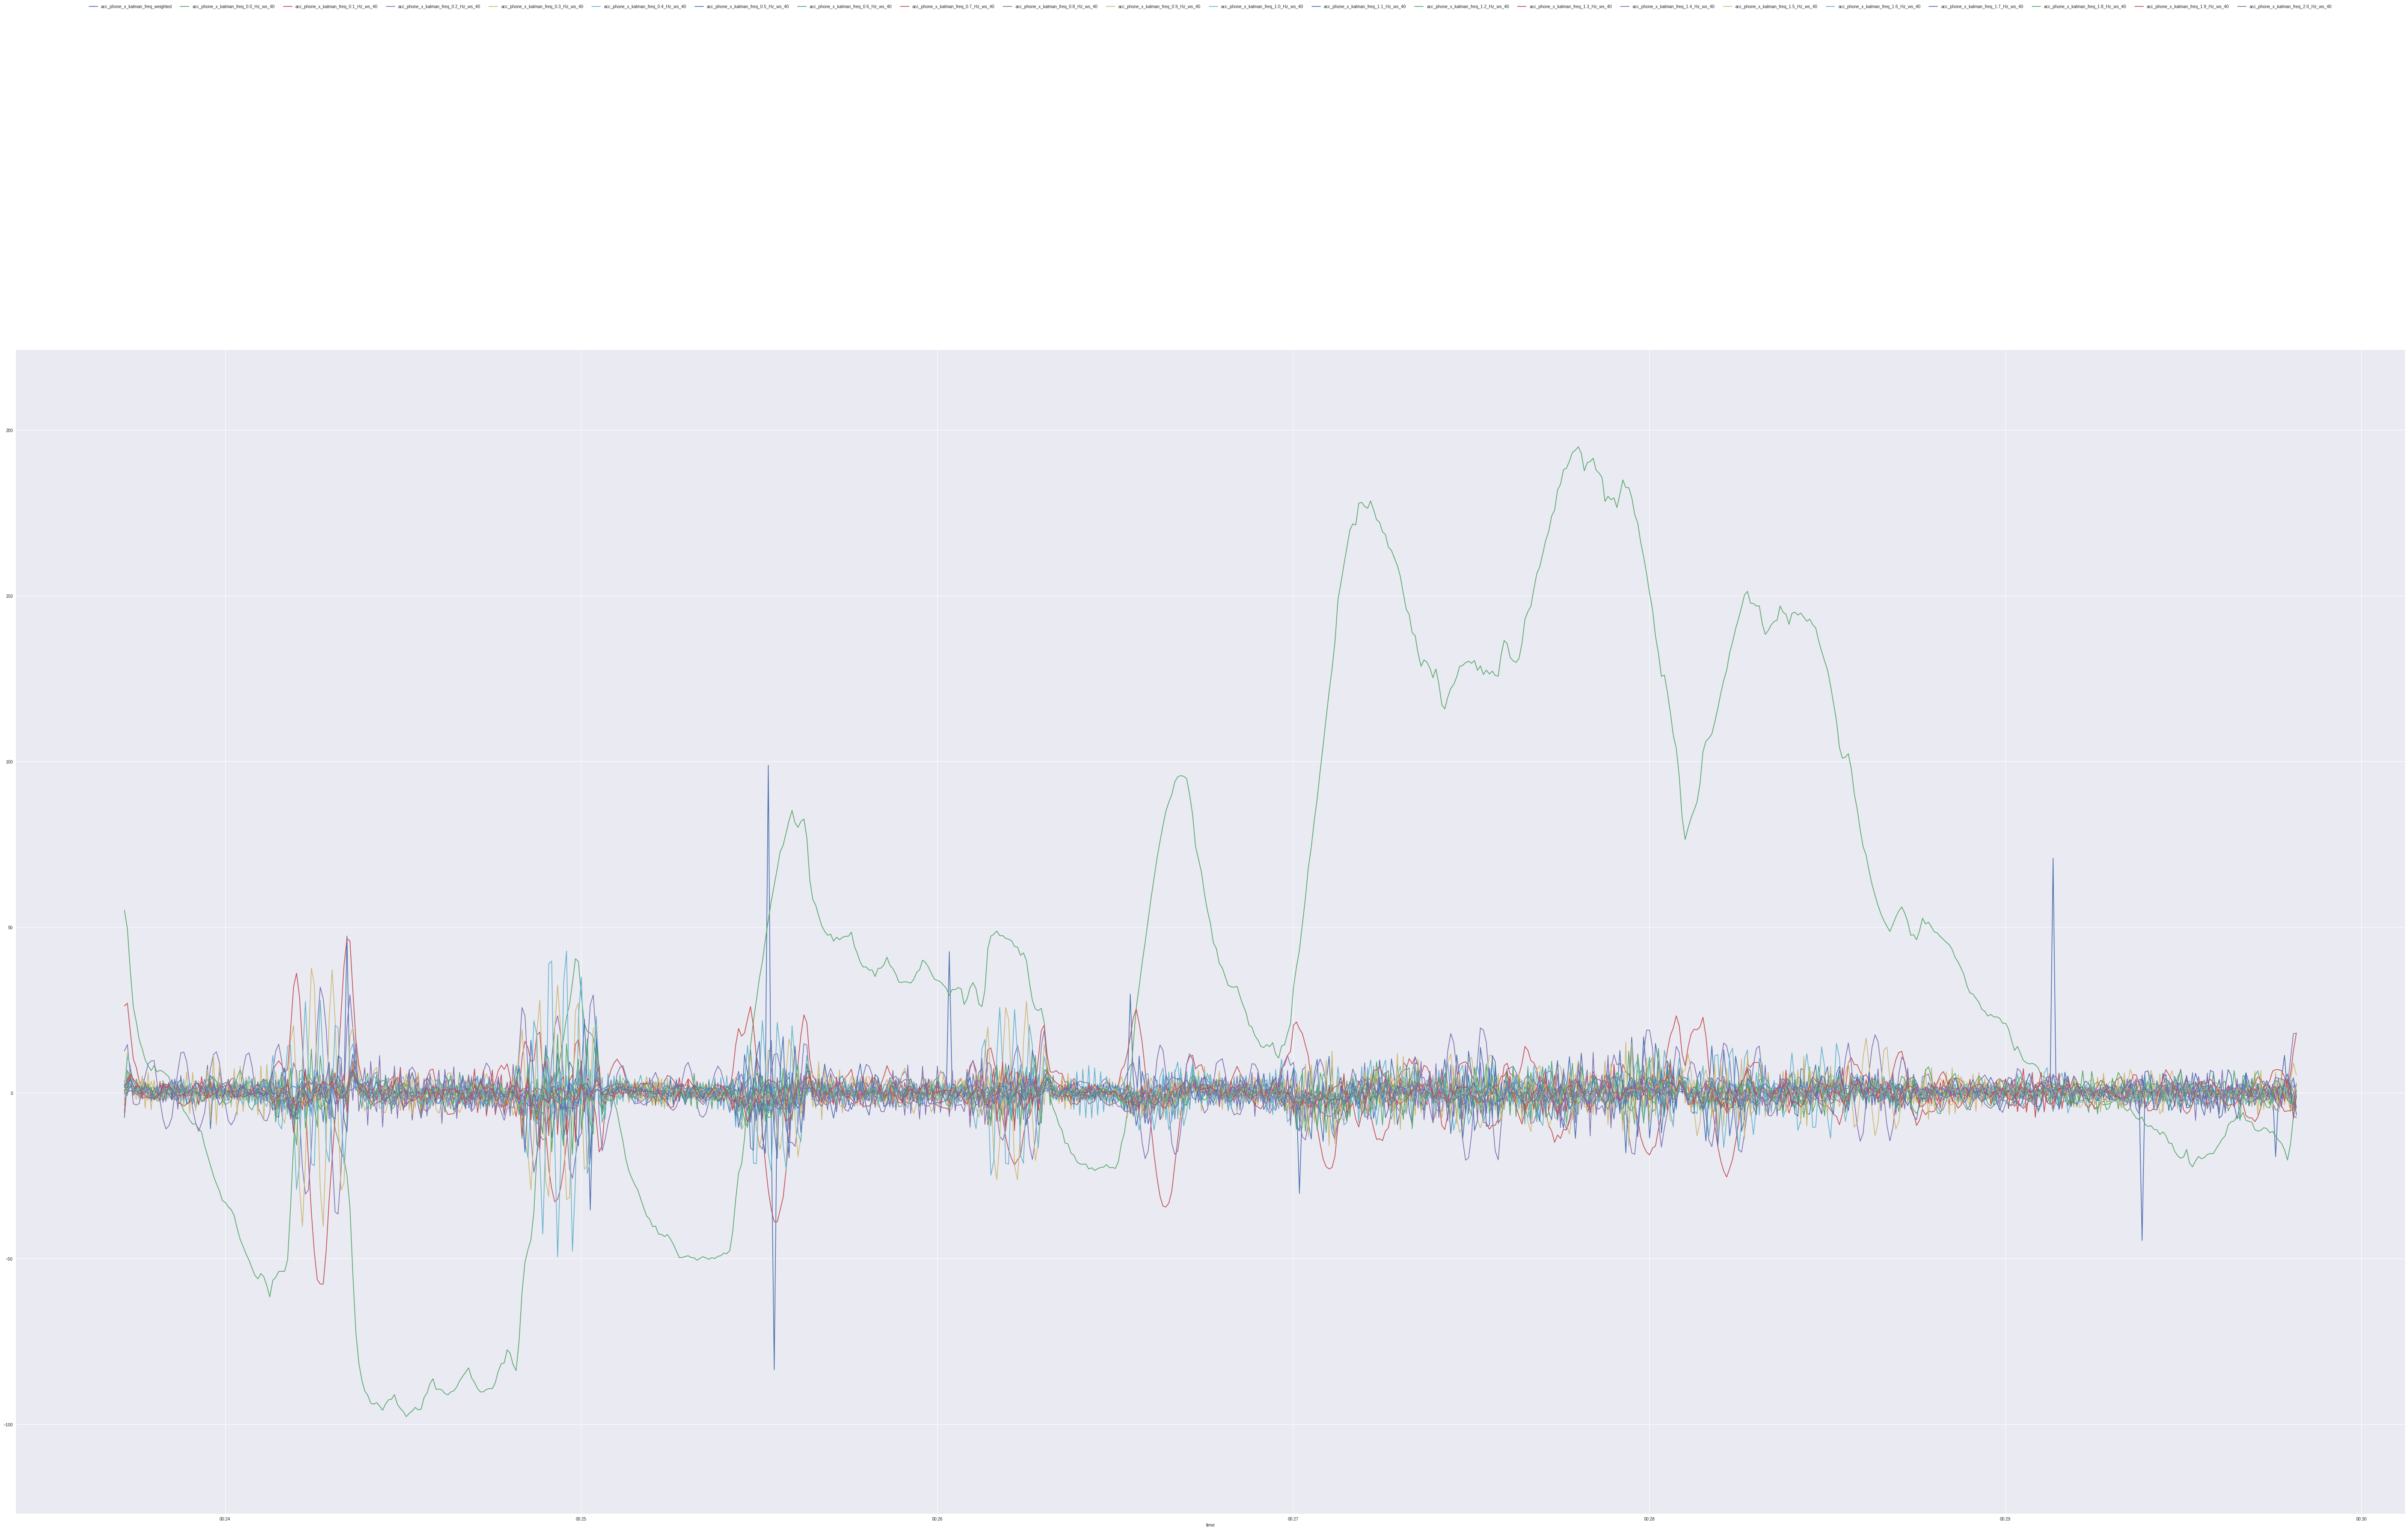

In [65]:
rcParams['figure.figsize'] = (100,50)
DataViz.plot_dataset(dataset_fft,['acc_phone_x_kalman_freq_'],['like'],['line'])